In [1]:
import os.path as osp
from utils import loadData
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
import uproot
import awkward as ak
import torch
from numba import jit
from torch_geometric.data import Dataset, download_url, InMemoryDataset
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
pickle_data = './dataset_closeByDoublePion_LC/'


print("===== Loading Files ...")
el, e, nf, en_lay = loadData(pickle_data, num_files = -1, lc_data = True)
print("===== Loaded!")

===== Loading Files ...
===== Loaded!


In [3]:
edge_data = []
edge_label = []
node_data = []
en_layers = []
print("Preparing dataset ...")
for i,X in enumerate(nf):
    for ev in range(len(X)):
        if len(e[i][ev]) == 0:
            print(f"event {ev} edges {e[i][ev]}")
            continue # skip events with no edges
        else:
            X_ev = []
            edge_data.append(e[i][ev])
            edge_label.append([np.float32(edg) for edg in el[i][ev]])
            en_layers.append(en_lay[i][ev])
            for field in X[ev].fields:
                if "sigma" in field:
                    continue
                X_ev.append(np.float32(ak.to_numpy(X[ev][field])))
            node_data.append(X_ev)

print(f"{len(node_data)} total events in dataset")

Preparing dataset ...
154500 total events in dataset


Text(0, 1, 'Sum LC Energy')

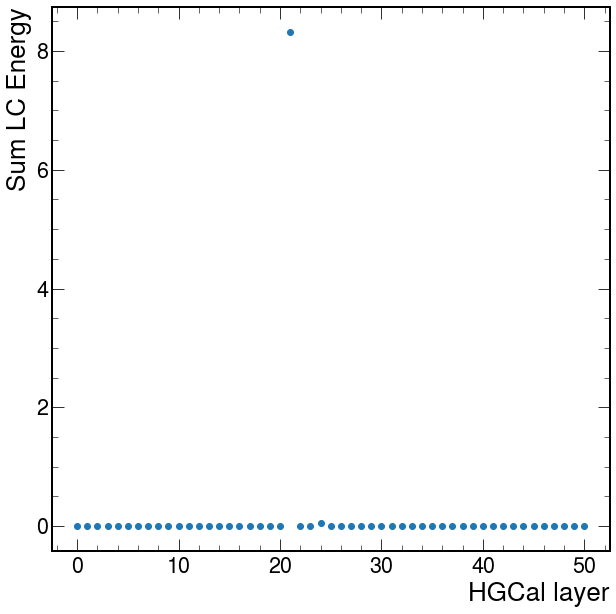

In [9]:
plt.scatter(np.arange(0,51), en_layers[0][3])
plt.xlabel("HGCal layer")
plt.ylabel("Sum LC Energy")

In [4]:
@jit(nopython=True)
def get_shower_max_extent(en_lay_ts):
    shower_max = np.argmax(en_lay_ts)
    last_layer = 50
    start = 0
    for l, e in enumerate(en_lay_ts):
        if e > 0:
            start = l
            break
    stop = 0
    for l in range(len(en_lay_ts)):
        if en_lay_ts[-(l+1)] > 0:
            stop = last_layer - l
            break
    if stop < start:
        stop = start
    
    return shower_max, start, stop

In [ ]:
data_list = []
dataLay_list = []
trainRatio = 0.8
valRatio = 0.1
testRatio = 0.1

nSamples = len(node_data)

nTrain = int( trainRatio * nSamples  )
nVal = int( valRatio * nSamples )

for ev in range(len(node_data[:nTrain+nVal])):
    x_np = np.array(node_data[ev]).T
    x_coord_slice = x_np[:, [0,1,2]]
    x_rest_slice = x_np[:, [9,10,11]]
    x_en_lay = np.array(en_layers[ev])
            
    #x_en_lay_windowed = []
    x_en_lay_digest = []
    
    for ts, en_lay_ts in enumerate(x_en_lay):
        
        max_lay, start, stop = get_shower_max_extent(en_lay_ts)
        #print(f"max {max_lay} start {start} stop {stop} len {stop-start} E {np.sum(en_lay_ts)}")
        x_en_lay_digest.append([max_lay, stop-start])

        '''
        maxe = en_lay_ts[maxe_lays[ts]]
        en_lay_windowed = [e/maxe for lay, e in enumerate(en_lay_ts) if (maxe_lays[ts] - 5 < lay and lay < maxe_lays[ts] + 5)]
        
        filter_len = 9
        w_len = len(en_lay_windowed)
        if w_len < filter_len: # max e layer is too close to front/back
            # zero pad at the end
            en_lay_windowed = np.pad(en_lay_windowed, (0, filter_len-w_len))
        x_en_lay_windowed.append(en_lay_windowed)
        '''
        
    #x_en_lay_windowed = np.array(x_en_lay_windowed)
    
    scaler = StandardScaler()
    scaler.fit(x_coord_slice)
    x_coord_norm = scaler.transform(x_coord_slice)
    
    scaler.fit(x_rest_slice)
    x_rest_norm = scaler.transform(x_rest_slice)
     
    x_norm = np.concatenate((x_coord_norm, x_np[:,[3,4,5,6,7,8]], x_rest_norm), axis=1)
    
    x = torch.from_numpy(x_norm)
    e_label = torch.from_numpy(np.array(edge_label[ev]))
    edge_index = torch.from_numpy(edge_data[ev])
    data = Data(x=x, num_nodes=torch.tensor(x.shape[0]), edge_index=edge_index, edge_label=e_label, en_hgcal_layers = torch.from_numpy(np.array(x_en_lay_digest)))
    dataLay = Data(en_hgcal_layers = x_en_lay)
    data_list.append(data)
    dataLay_list.append(dataLay)
    
# test split is not normalized here
test_data_list = []
for ev in range(len(node_data[nTrain+nVal:])):
    x_np = np.array(node_data[ev]).T
    #x_en_lay = torch.from_numpy(np.array(en_layers[ev]))
    x_en_lay = np.array(en_layers[ev])
            
    x_en_lay_digest = []
    
    for ts, en_lay_ts in enumerate(x_en_lay):
        max_lay, start, stop = get_shower_max_extent(en_lay_ts)
        x_en_lay_digest.append([max_lay, stop-start])
        
    '''
    x_coord_slice = x_np[:, [0,1,2]]
    x_rest_slice = x_np[:, [9,10,11,12,13,14]]
    
    scaler = StandardScaler()
    scaler.fit(x_coord_slice)
    x_coord_norm = scaler.transform(x_coord_slice)

    scaler.fit(x_rest_slice)
    x_rest_norm = scaler.transform(x_rest_slice)
     
    x_norm = np.concatenate((x_coord_norm, x_np[:,[3,4,5,6,7,8]], x_rest_norm), axis=1)
    '''
    
    #x = torch.from_numpy(x_np)
    #e_label = torch.from_numpy(np.array(edge_label[ev]))
    #edge_index = torch.from_numpy(edge_data[ev])
    #data = Data(x=x, num_nodes=torch.tensor(x.shape[0]), edge_index=edge_index, edge_label=e_label)
    data = [x_np, np.array(edge_label[ev]), edge_data[ev], x_en_lay_digest]
    test_data_list.append(data)



trainDataset = data_list[:nTrain]           # training dataset
trainDatasetLay = dataLay_list[:nTrain]           # training dataset
valDataset = data_list[nTrain:]  # validation dataset
testDataset = test_data_list       # test datase

path = "./dataProcessed_closeByDoublePion_LC/"
torch.save(trainDataset, path + 'dataTraining.pt')
torch.save(trainDatasetLay, path + 'dataTrainingLay.pt')
torch.save(valDataset, path + 'dataVal.pt')
torch.save(testDataset, path + 'dataTest.pt')
print("===== Saved dataset!")